In [11]:
!pip install torchsummary

In [12]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import time
from torchvision import models

# For Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn

In [13]:
%matplotlib inline

In [14]:
data_dir = "../input/plantvillagecolor/color"
# data_dir = "/content/drive/MyDrive/COMP6721-Project/PlantVillage-Dataset"

diseases = os.listdir(data_dir)

In [15]:
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [16]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [17]:
# Unique plants in the dataset
print("Number of plants: {}".format(len(plants)))
print(f"Unique Plants are: ")
for idx, plant in enumerate(plants):
    print(str(idx + 1) + '. ' + plant)


Number of plants: 14
Unique Plants are: 
1. Tomato
2. Grape
3. Orange
4. Soybean
5. Squash
6. Potato
7. Corn_(maize)
8. Strawberry
9. Peach
10. Apple
11. Blueberry
12. Cherry_(including_sour)
13. Pepper,_bell
14. Raspberry


In [18]:
# number of unique diseases
print("Total number of diseases: {}".format(NumberOfDiseases))


Total number of diseases: 26


In [19]:
# Number of images for each disease
disease_class_size = {}
for disease in diseases:
    disease_class_size[disease] = len(os.listdir(data_dir + '/' + disease))
    
# converting the disease_class_size dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(disease_class_size.values(), index=disease_class_size.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1909
Tomato___healthy,1591
Grape___healthy,423
Orange___Haunglongbing_(Citrus_greening),5507
Soybean___healthy,5090
Squash___Powdery_mildew,1835
Potato___healthy,152
Corn_(maize)___Northern_Leaf_Blight,985
Tomato___Early_blight,1000
Tomato___Septoria_leaf_spot,1771


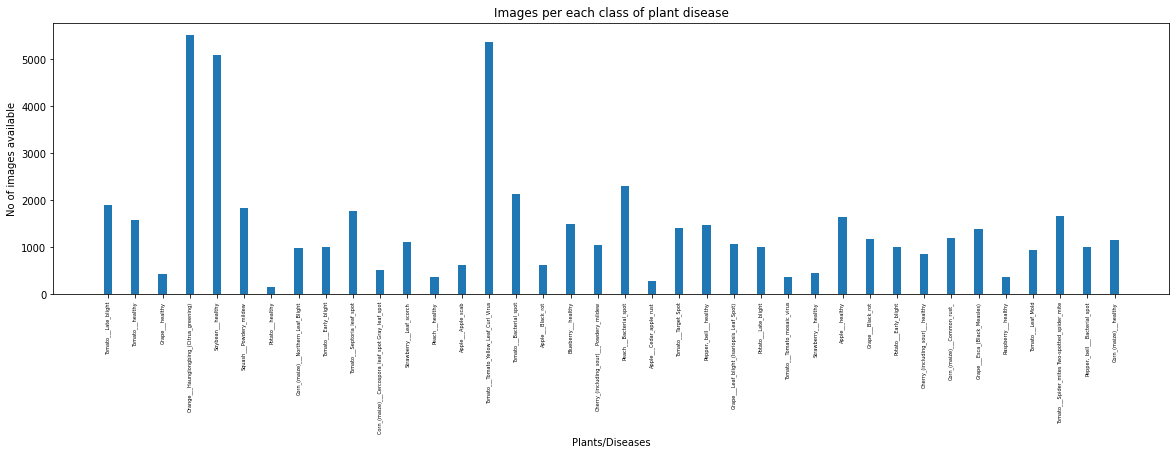

In [20]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in disease_class_size.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

plt.savefig('/kaggle/working/ClassDistribution_PlantVillage_AfterOfflineAugmentation')

In [21]:
## Split Train, Test and Validation ##

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

get_files_from_folder(data_dir)

def load_data(path, validation_split, test_split, batch_size):
    transform_dict = {
        "src": transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.27129, 0.28836, 0.26273], std=[0.09086, 0.12649, 0.08288]),
            transforms.Resize((224, 224))
        ])
    }
    
    dataset = ImageFolder(root=path, transform=transform_dict["src"])
    
    dataset_size = len(dataset)
    validation_size = int(validation_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - (test_size + validation_size)

    # TODO: Split classes into equal sizes?!
    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
    
    return train_dataset, validation_dataset, test_dataset

In [22]:
train_dataset, validation_dataset, test_dataset = load_data(data_dir, 0.1, 0.2, 200)

In [23]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 34


In [24]:

print(f"There are {len(train_dataset) + len(validation_dataset) + len(test_dataset)} images in total")

print(f"There are {len(train_dataset)} images for training")

print(f"There are {len(validation_dataset)} images for validation")

print(f"There are {len(test_dataset.dataset)} images for testing")

There are 54305 images in total
There are 38014 images for training
There are 5430 images for validation
There are 54305 images for testing


In [25]:
# for checking some images from training dataset
def show_image(image, label):
    # print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

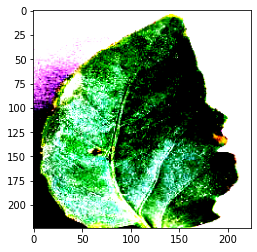

In [26]:
show_image(*train_dataset[24])

In [27]:
# Setting the seed value
random_seed = 7
a = torch.manual_seed(random_seed)

In [28]:
# setting the batch size
batch_size = 32

# Load data to DataLoaders for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [29]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

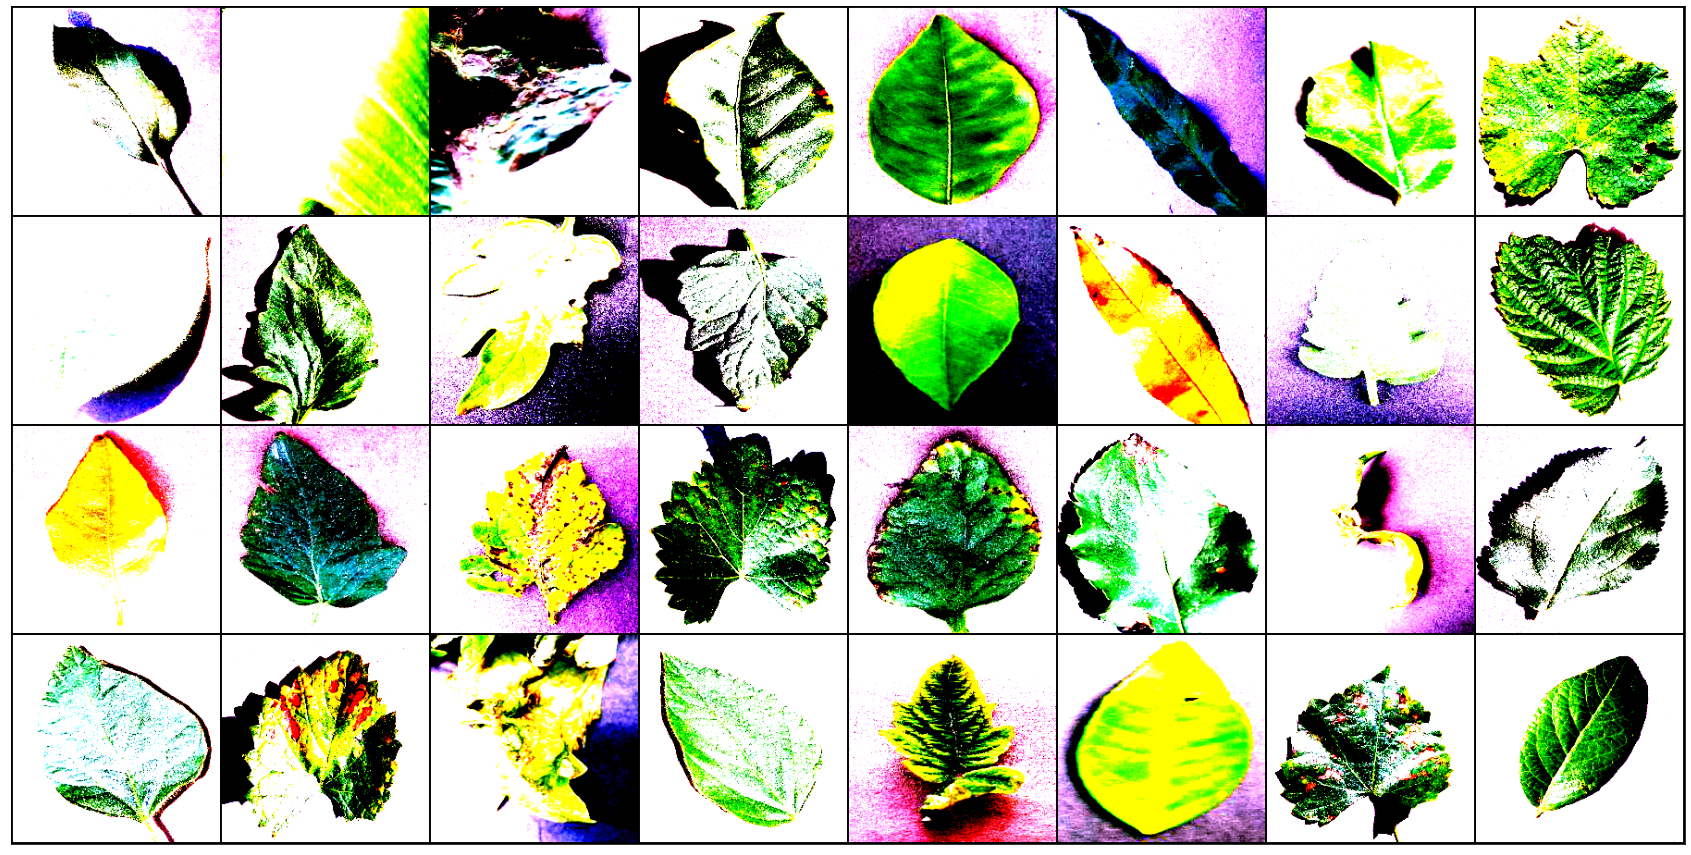

In [30]:
show_batch(train_dataloader)

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

cuda:0


In [32]:
# Moving data into GPU
train_dataloader = DeviceDataLoader(train_dataloader, device)
validation_dataloader = DeviceDataLoader(validation_dataloader, device)

In [33]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [34]:
model_alexnet = models.alexnet(pretrained=False)
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [35]:
model_alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=len(train_dataset.dataset.classes))
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [36]:
# getting summary of the model
INPUT_SHAPE = (3, 224, 336)
print(summary(model_alexnet.cuda(), (INPUT_SHAPE)))
# print(summary(model.cpu(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 83]          23,296
              ReLU-2           [-1, 64, 55, 83]               0
         MaxPool2d-3           [-1, 64, 27, 41]               0
            Conv2d-4          [-1, 192, 27, 41]         307,392
              ReLU-5          [-1, 192, 27, 41]               0
         MaxPool2d-6          [-1, 192, 13, 20]               0
            Conv2d-7          [-1, 384, 13, 20]         663,936
              ReLU-8          [-1, 384, 13, 20]               0
            Conv2d-9          [-1, 256, 13, 20]         884,992
             ReLU-10          [-1, 256, 13, 20]               0
           Conv2d-11          [-1, 256, 13, 20]         590,080
             ReLU-12          [-1, 256, 13, 20]               0
        MaxPool2d-13            [-1, 256, 6, 9]               0
AdaptiveAvgPool2d-14            [-1, 25

In [37]:
optimizer = torch.optim.Adam(model_alexnet.classifier[6].parameters(), lr=0.001)

In [38]:
loss_fn = nn.CrossEntropyLoss()

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model_alexnet.to(device)

accuracy_validation = []
accuracy_train = []
loss_validation = []
loss_train = []


num_epochs = 40
total_steps = len(train_dataloader)
t1 = time.time()

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model_alexnet(images)
        loss = loss_fn(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            accuracy = ((correct / total) * 100)
            accuracy_train.append(accuracy)
            loss_train.append(loss.item())
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy))
            
            model_alexnet.eval()
            with torch.no_grad():
                correct_validation_labels = 0
                total_validation_labels = 0

                for validation_data in validation_dataloader:
                    validation_images, validation_labels = validation_data[0].to(device), validation_data[1].to(device)
                    predicted_outputs = model_alexnet(validation_images)

                    _, validation_prediction = torch.max(predicted_outputs.data, 1)
                    total_validation_labels += validation_labels.size(0)
                    correct_validation_labels += (validation_prediction == validation_labels).sum().item()
                val_loss = loss_fn(predicted_outputs, validation_labels)
                
                val_accuracy = ((correct_validation_labels / total_validation_labels) * 100)
                
                accuracy_validation.append(val_accuracy)
                loss_validation.append(val_loss.item())
            
                print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, val_loss.item(), val_accuracy))
     
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Device: cuda:0
Epoch [1/40], Step [100/1188], Loss: 3.3040, Accuracy: 18.75%
Epoch [1/40], Loss: 3.3085, Validation Accuracy: 9.98%
Epoch [1/40], Step [200/1188], Loss: 3.2789, Accuracy: 25.00%
Epoch [1/40], Loss: 3.2440, Validation Accuracy: 22.58%
Epoch [1/40], Step [300/1188], Loss: 3.2751, Accuracy: 9.38%
Epoch [1/40], Loss: 3.1928, Validation Accuracy: 18.99%
Epoch [1/40], Step [400/1188], Loss: 3.4087, Accuracy: 9.38%
Epoch [1/40], Loss: 3.2076, Validation Accuracy: 25.16%
Epoch [1/40], Step [500/1188], Loss: 3.2622, Accuracy: 21.88%
Epoch [1/40], Loss: 3.1382, Validation Accuracy: 22.23%
Epoch [1/40], Step [600/1188], Loss: 3.1632, Accuracy: 18.75%
Epoch [1/40], Loss: 3.0601, Validation Accuracy: 19.91%
Epoch [1/40], Step [700/1188], Loss: 3.2837, Accuracy: 25.00%
Epoch [1/40], Loss: 3.0441, Validation Accuracy: 24.88%
Epoch [1/40], Step [800/1188], Loss: 2.9643, Accuracy: 28.12%
Epoch [1/40], Loss: 2.9929, Validation Accuracy: 24.79%
Epoch [1/40], Step [900/1188], Loss: 2.9175,

In [40]:
torch.save(model_alexnet, '/kaggle/working/Model_PlantVillage-AlexNet.pth')

# model = torch.load('model.pth')

In [41]:
print (accuracy_train)

[18.75, 25.0, 9.375, 9.375, 21.875, 18.75, 25.0, 28.125, 25.0, 25.0, 21.875, 25.0, 28.125, 25.0, 18.75, 18.75, 15.625, 15.625, 25.0, 15.625, 28.125, 34.375, 40.625, 18.75, 31.25, 37.5, 40.625, 46.875, 31.25, 37.5, 25.0, 56.25, 56.25, 40.625, 37.5, 53.125, 56.25, 43.75, 34.375, 31.25, 40.625, 43.75, 43.75, 40.625, 53.125, 50.0, 68.75, 50.0, 40.625, 46.875, 50.0, 40.625, 56.25, 40.625, 40.625, 53.125, 59.375, 53.125, 56.25, 62.5, 56.25, 56.25, 56.25, 59.375, 37.5, 65.625, 56.25, 53.125, 50.0, 71.875, 59.375, 59.375, 40.625, 56.25, 59.375, 34.375, 56.25, 59.375, 65.625, 53.125, 34.375, 50.0, 59.375, 71.875, 68.75, 40.625, 46.875, 50.0, 65.625, 50.0, 50.0, 59.375, 62.5, 62.5, 56.25, 46.875, 78.125, 65.625, 53.125, 59.375, 59.375, 56.25, 71.875, 53.125, 56.25, 59.375, 53.125, 50.0, 68.75, 53.125, 68.75, 65.625, 78.125, 75.0, 56.25, 62.5, 50.0, 59.375, 53.125, 37.5, 75.0, 65.625, 59.375, 56.25, 62.5, 65.625, 68.75, 65.625, 56.25, 75.0, 65.625, 65.625, 71.875, 50.0, 50.0, 65.625, 53.125, 59.3

In [42]:
print (accuracy_validation)

[9.981583793738489, 22.578268876611418, 18.987108655616943, 25.156537753222835, 22.228360957642725, 19.90791896869245, 24.880294659300183, 24.788213627992633, 23.664825046040516, 22.94659300184162, 22.65193370165746, 24.82504604051565, 25.50644567219153, 25.35911602209945, 26.464088397790054, 27.10865561694291, 27.18232044198895, 27.771639042357275, 31.123388581952117, 29.447513812154696, 32.06261510128913, 32.707182320441994, 33.53591160220994, 34.45672191528545, 36.721915285451196, 39.18968692449356, 37.918968692449354, 38.71086556169429, 40.90239410681399, 39.52117863720074, 40.81031307550644, 40.773480662983424, 40.90239410681399, 43.35174953959484, 42.96500920810313, 43.370165745856355, 43.683241252302025, 45.21178637200737, 45.34069981583794, 46.16942909760589, 45.04604051565377, 47.95580110497237, 46.316758747697975, 46.758747697974215, 47.86372007366482, 47.42173112338858, 48.25046040515654, 49.079189686924494, 49.06077348066298, 49.24493554327808, 48.58195211786372, 48.8213627

In [43]:
print (loss_train)

[3.303966522216797, 3.278928518295288, 3.275078296661377, 3.408724308013916, 3.2622265815734863, 3.163174629211426, 3.2837438583374023, 2.964254379272461, 2.9175267219543457, 2.959291696548462, 3.021977663040161, 2.9643824100494385, 2.805915594100952, 3.0038371086120605, 2.9533681869506836, 3.0482218265533447, 2.8838117122650146, 2.9698081016540527, 2.8506367206573486, 2.78189754486084, 2.7541470527648926, 2.676295757293701, 2.4223029613494873, 2.776386260986328, 2.4507312774658203, 2.749735116958618, 2.39475154876709, 2.3958189487457275, 2.5263781547546387, 2.630321979522705, 2.5737881660461426, 2.027869701385498, 1.8722054958343506, 2.4612154960632324, 2.3798577785491943, 2.0894699096679688, 2.091545581817627, 2.2414774894714355, 2.464585781097412, 2.444758415222168, 2.2452569007873535, 2.334665060043335, 2.055147647857666, 2.272383689880371, 1.986425757408142, 2.3160035610198975, 1.9049241542816162, 2.1854653358459473, 2.4049108028411865, 2.136050224304199, 1.9884618520736694, 2.390

In [44]:
print (loss_validation)

[3.3084945678710938, 3.2439918518066406, 3.192845106124878, 3.2075600624084473, 3.138218879699707, 3.060138463973999, 3.0441396236419678, 2.992868185043335, 2.9269914627075195, 2.9132752418518066, 2.8630530834198, 2.7858083248138428, 2.7925291061401367, 2.7815117835998535, 2.7270426750183105, 2.685236692428589, 2.636767625808716, 2.5920162200927734, 2.5915181636810303, 2.5508832931518555, 2.5246729850769043, 2.534554958343506, 2.473536729812622, 2.4319138526916504, 2.4334824085235596, 2.402594804763794, 2.351691961288452, 2.3123483657836914, 2.3086047172546387, 2.291898727416992, 2.2380335330963135, 2.292813301086426, 2.2266504764556885, 2.178013801574707, 2.155696153640747, 2.1555938720703125, 2.121363639831543, 2.106700897216797, 2.1300346851348877, 2.0632078647613525, 2.014702796936035, 2.0293824672698975, 2.062610626220703, 1.9666763544082642, 1.9790596961975098, 1.9554446935653687, 1.9601315259933472, 1.9659281969070435, 1.8934723138809204, 1.8648930788040161, 1.8879708051681519, 

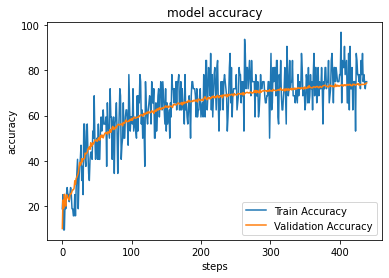

In [45]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_validation, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/Accurary_Plot_PlantVillage-AlexNet')
plt.show()

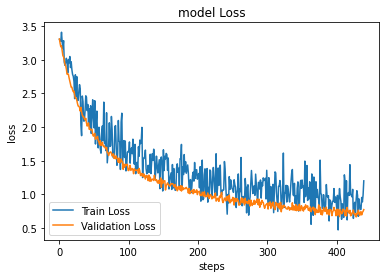

In [46]:
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_validation, label="Validation Loss")
plt.legend(loc="lower left")
plt.savefig('/kaggle/working/Loss_Plot_PlantVillage-AlexNet')
plt.show()



In [47]:
model_alexnet.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in validation_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_alexnet(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()

    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Validation Set: {:.2f}%".format(test_accuracy))

Accuracy on Validation Set: 73.83%


In [48]:
y_pred = []
y_true = []
features_tsne = None

model_alexnet.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in test_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_alexnet(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()
        
        prediction_result = test_prediction.data.cpu().numpy()
        gt_label = test_labels.data.cpu().numpy()
        
        y_pred.extend(prediction_result) # Save Prediction
        y_true.extend(gt_label) # Save Truth
        
        # For t-SNE
        curr_f = predicted_outputs.cpu().numpy()
        if features_tsne is not None:
            features_tsne = np.concatenate((features_tsne, curr_f))
        else:
            features_tsne = curr_f
        
    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Test Set: {:.2f}%".format(test_accuracy))

Accuracy on Test Set: 75.20%


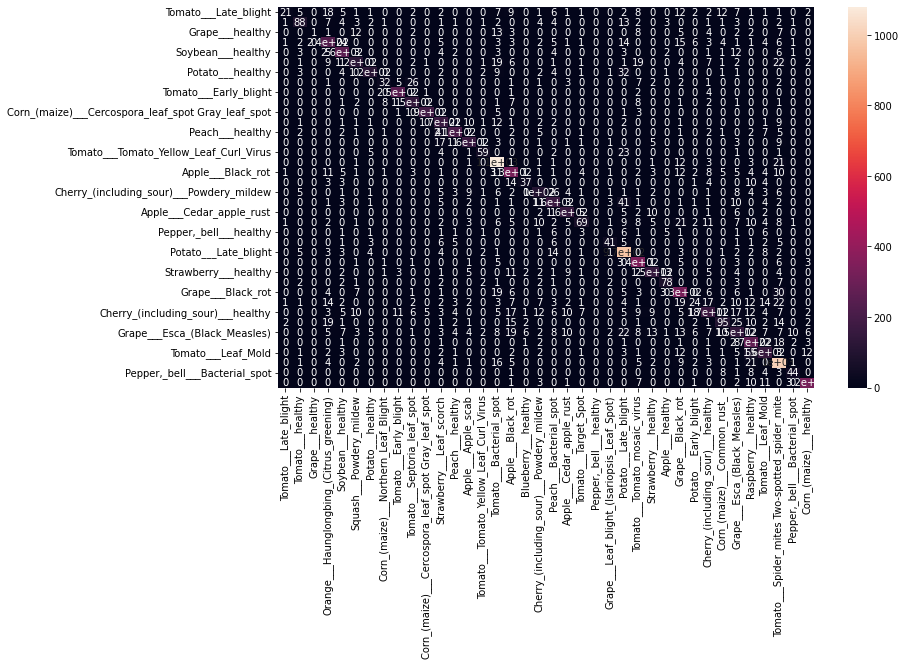

In [49]:
confusion_matrix_vec = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(confusion_matrix_vec,
                     index = [i for i in diseases],
                     columns = [i for i in diseases])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('/kaggle/working/Confusion_Matrix_PlantVillage-Alexnet.png')

In [50]:
str(y_pred)


'[24, 13, 33, 17, 35, 24, 13, 30, 25, 19, 13, 15, 37, 11, 3, 15, 24, 34, 37, 24, 15, 16, 16, 28, 16, 25, 35, 35, 30, 15, 3, 9, 21, 15, 24, 35, 13, 15, 26, 15, 19, 33, 28, 3, 15, 24, 25, 4, 33, 28, 24, 35, 10, 35, 28, 24, 35, 35, 31, 8, 25, 10, 35, 32, 3, 9, 11, 13, 15, 8, 7, 8, 37, 37, 35, 21, 33, 24, 32, 33, 15, 16, 18, 12, 35, 3, 28, 28, 4, 15, 7, 3, 34, 15, 18, 28, 25, 27, 35, 5, 35, 28, 25, 20, 10, 11, 35, 30, 24, 8, 35, 12, 35, 35, 36, 11, 5, 24, 24, 30, 32, 27, 35, 26, 34, 35, 37, 16, 24, 32, 35, 3, 11, 15, 15, 28, 35, 30, 15, 31, 13, 33, 24, 33, 3, 10, 4, 30, 25, 24, 7, 4, 3, 28, 24, 24, 24, 36, 31, 18, 29, 26, 15, 3, 33, 35, 29, 15, 19, 30, 25, 25, 20, 16, 24, 4, 12, 15, 3, 35, 13, 35, 21, 4, 15, 10, 25, 24, 3, 18, 12, 37, 1, 33, 25, 33, 35, 15, 35, 16, 12, 11, 24, 31, 16, 34, 24, 32, 15, 35, 4, 24, 26, 34, 35, 16, 15, 21, 16, 12, 33, 25, 11, 37, 18, 35, 35, 13, 17, 25, 24, 6, 6, 19, 18, 15, 32, 23, 15, 6, 21, 10, 35, 31, 34, 8, 16, 3, 13, 15, 27, 37, 33, 5, 15, 16, 37, 31, 25,

In [51]:
str(y_true)

'[24, 13, 35, 31, 15, 24, 13, 1, 25, 19, 13, 28, 37, 12, 3, 15, 24, 34, 37, 19, 5, 30, 16, 24, 16, 22, 35, 35, 2, 15, 34, 7, 21, 15, 24, 35, 35, 35, 21, 15, 19, 33, 28, 3, 15, 19, 28, 4, 33, 7, 29, 35, 10, 35, 0, 24, 35, 35, 31, 8, 7, 10, 35, 32, 29, 9, 11, 13, 15, 8, 7, 8, 37, 37, 29, 21, 35, 24, 32, 34, 15, 16, 18, 12, 33, 1, 34, 28, 4, 15, 1, 3, 34, 35, 18, 15, 25, 26, 35, 2, 35, 28, 25, 20, 10, 13, 35, 30, 24, 8, 29, 12, 35, 12, 36, 6, 5, 24, 24, 30, 20, 26, 35, 26, 34, 35, 37, 21, 23, 29, 35, 3, 11, 15, 15, 28, 35, 15, 15, 31, 13, 33, 24, 33, 3, 10, 4, 30, 25, 24, 7, 3, 3, 28, 24, 24, 30, 32, 31, 30, 29, 26, 10, 3, 33, 35, 30, 15, 14, 30, 25, 25, 26, 16, 24, 4, 12, 15, 3, 35, 13, 35, 22, 4, 15, 10, 9, 24, 3, 12, 11, 37, 1, 33, 25, 33, 35, 15, 35, 16, 12, 13, 24, 31, 17, 34, 24, 29, 15, 35, 4, 24, 26, 32, 35, 16, 15, 21, 31, 12, 35, 25, 11, 37, 18, 35, 3, 26, 17, 25, 24, 6, 6, 19, 1, 30, 32, 23, 15, 6, 21, 10, 35, 32, 34, 30, 35, 3, 13, 15, 27, 37, 33, 5, 15, 0, 37, 36, 0, 31, 27, 

In [52]:
# (True Positive + True Negative) / Total Predictions
accuracy = accuracy_score(y_true, y_pred)

# True Positive / (True Positive + False Positive)
precision = precision_score(y_true, y_pred, average='weighted')

# True Positive / (True Positive + False Negative)
sensitivity_recall = recall_score(y_true, y_pred, average='weighted')

# True Negative / (True Negative + False Positive)
specificity = recall_score(y_true, y_pred, average='weighted')

# 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))
f1_score = f1_score(y_true, y_pred, average='weighted')
      
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Sensitivity_recall: {:.2f}%".format(sensitivity_recall*100))
print("Specificity: {:.2f}%".format(specificity*100))
print("F1 Score: {:.2f}%".format(f1_score*100))

Accuracy: 75.20%
Precision: 74.38%
Sensitivity_recall: 75.20%
Specificity: 75.20%
F1 Score: 73.69%


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
## TSNE ##

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate= 'auto', init='random').fit_transform(features_tsne)

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def visualize_both_tsne_points(diseases, tx1, ty1, labels1, tx2, ty2, labels2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 8))
    
    for disease_index in range(len(diseases)):
        ax1.title.set_text(title1)
        indices = [i for i, l in enumerate(labels1) if l == disease_index]
        current_tx = np.take(tx1, indices)
        current_ty = np.take(ty1, indices)
        ax1.scatter(current_tx, current_ty, label=diseases[disease_index])

    for disease_index in range(len(diseases)):
        ax2.title.set_text(title2)
        indices = [i for i, l in enumerate(labels2) if l == disease_index]
        current_tx = np.take(tx2, indices)
        current_ty = np.take(ty2, indices)
        ax2.scatter(current_tx, current_ty, label=diseases[disease_index])
    
    ax2.legend(bbox_to_anchor=(1, 1.01))
    plt.savefig('/kaggle/working/TNSE_Plot_PlantVillage-Alexnet')
    plt.show()

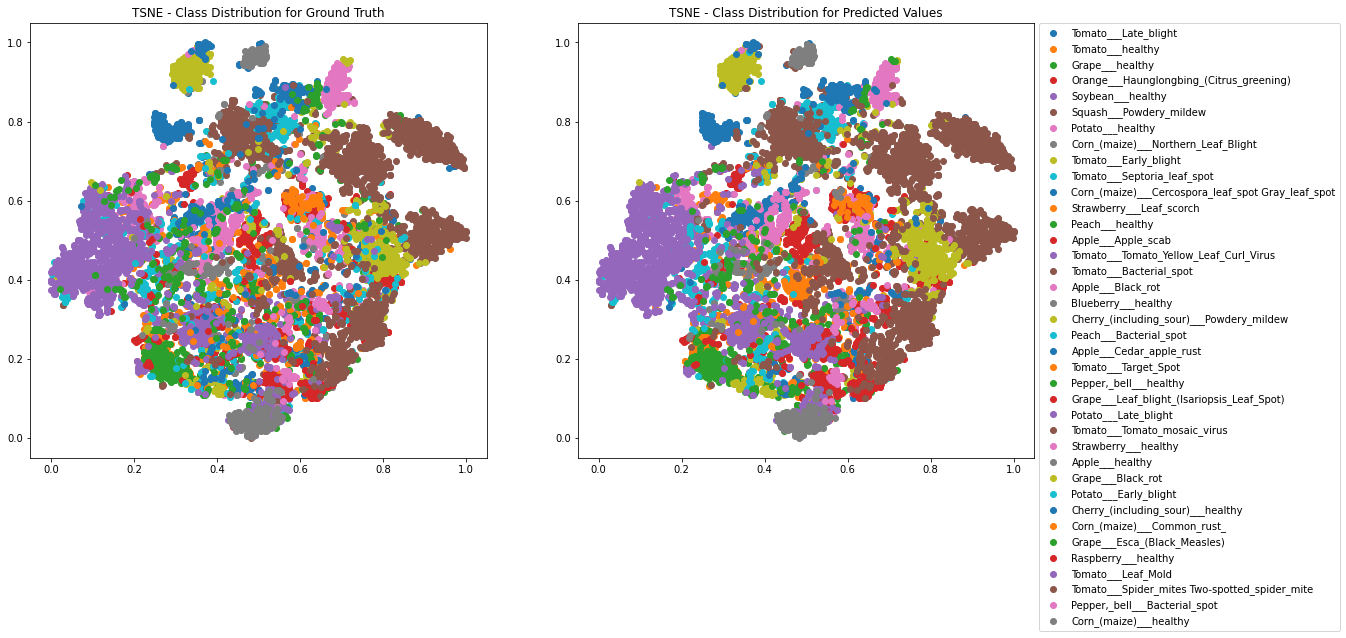

In [54]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_gt = tsne[:, 0]
ty_gt = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_gt = scale_to_01_range(tx_gt)
ty_gt = scale_to_01_range(ty_gt)


# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_pred = tsne[:, 0]
ty_pred = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_pred = scale_to_01_range(tx_pred)
ty_pred = scale_to_01_range(ty_pred)


# visualize the plot
visualize_both_tsne_points(diseases, tx_gt, ty_gt, y_true, tx_pred, ty_pred, y_pred, 'TSNE - Class Distribution for Ground Truth', 'TSNE - Class Distribution for Predicted Values')